In [1]:
%load_ext autoreload
%autoreload 2  
%reload_ext autoreload

In [2]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.special import softmax
from scipy.optimize import minimize

from bgspy.likelihood import SimplexModel
from bgspy.utils import load_pickle
from bgspy.optim import optim_plot
from bgspy.optim import equality_constraint_function, inequality_constraint_functions
from bgspy.optim import optim_diagnotics_plot


/home/vsb/projects/bprime/bgspy/likelihood.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  import tqdm.autonotebook as tqdm


In [3]:
plt.show()
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')

# MLE Diagnostics

### Merged Model

This is the simplest model, all CDS+phastcons+UTRs are merged into a single conserved feature type. The mixture with UTRs adds some complexity, since these are much less conserved.

In [22]:
fmd = load_pickle('../fits/hg38_cds_utrs_phastcons_merged_simplex/model_data_1000000.pkl')
#fd = load_pickle('../fits/hg38_cds_utrs_phastcons_simplex/model_data_1000000.pkl')
fd = load_pickle('../fits/hg38_cds_utrs_phastcons_simplex_full/model_data_1000000.pkl')

In [5]:
from bgspy.likelihood import negll_c

In [23]:
dat = fd
gm, Y, bgs_bins, features, bp = dat['gm'], dat['Y'], dat['bgs_bins'], dat['gm'], dat['bp']

mb = SimplexModel(w=gm.w, t=gm.t, logB=bp, Y=Y,
                  bins=bgs_bins, features=features) 

In [24]:
start = mb.random_start()

In [25]:
gm.w

array([1.00000000e-11, 6.30957344e-11, 3.98107171e-10, 2.51188643e-09,
       1.58489319e-08, 1.00000000e-07])

In [26]:
for i in range(1000):
    start = mb.random_start()
    assert(negll_c(start, Y, bp, mb.w) == negll_c(start, Y, bp, mb.w, version2=True))

In [27]:
start = mb.random_start()
negll_c(start, Y, bp, mb.w), negll_c(start, Y, bp, mb.w, version2=True)

(565344378126.4197, 565344378126.4197)

In [11]:
%%timeit
negll_c(mb.random_start(), Y, bp, mb.w, version2=False)

636 µs ± 2.86 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [12]:
%%timeit
negll_c(mb.random_start(), Y, bp, mb.w, version2=True)

351 µs ± 4.52 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [28]:
features = gm.features

In [14]:
features

['undefined']

In [15]:
gm.w, Y.shape

(array([1.00000000e-11, 6.30957344e-11, 3.98107171e-10, 2.51188643e-09,
        1.58489319e-08, 1.00000000e-07]),
 (2496, 2))

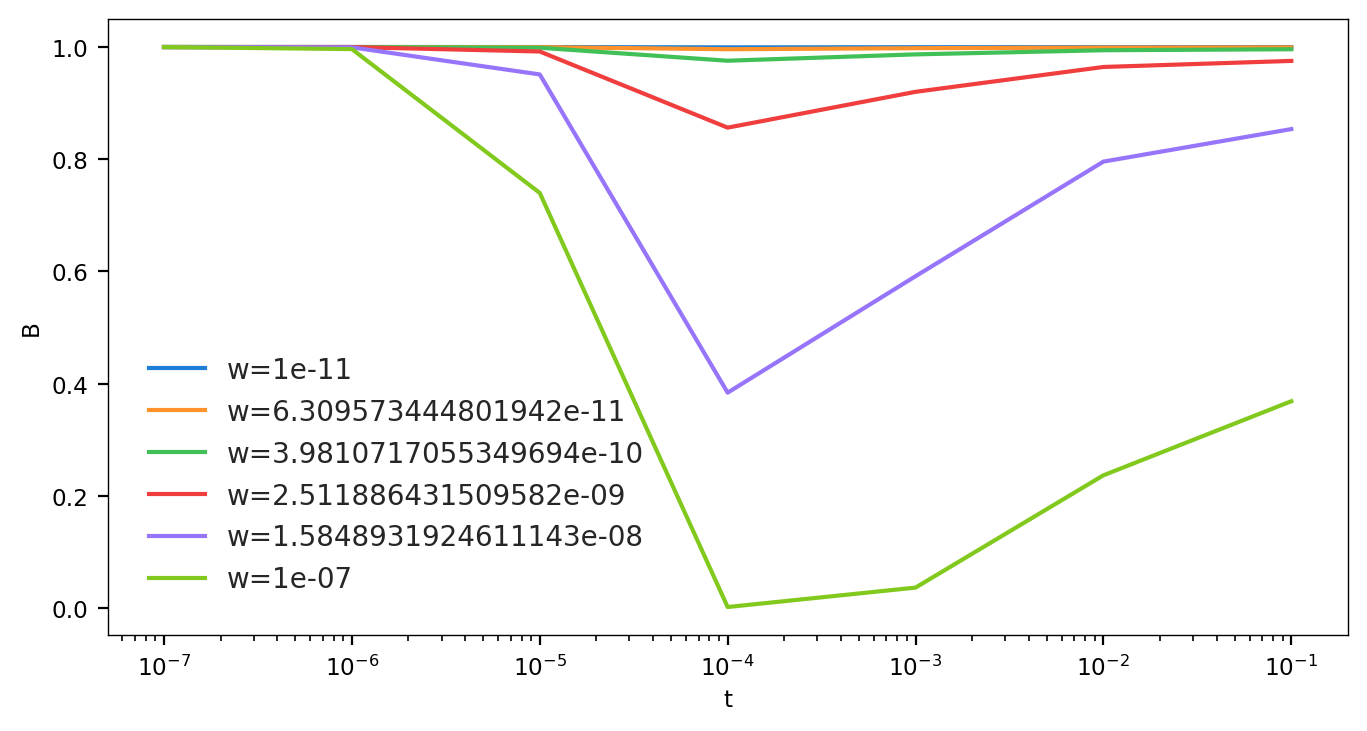

In [16]:
for i, w in enumerate(gm.w):
    plt.plot(gm.t, np.exp(bp[10, i, :, 0]), label=f"w={w}")
    plt.semilogx()
    plt.ylabel('B')
    plt.xlabel('t')
plt.legend()

/home/vsb/miniconda3/envs/bprime/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


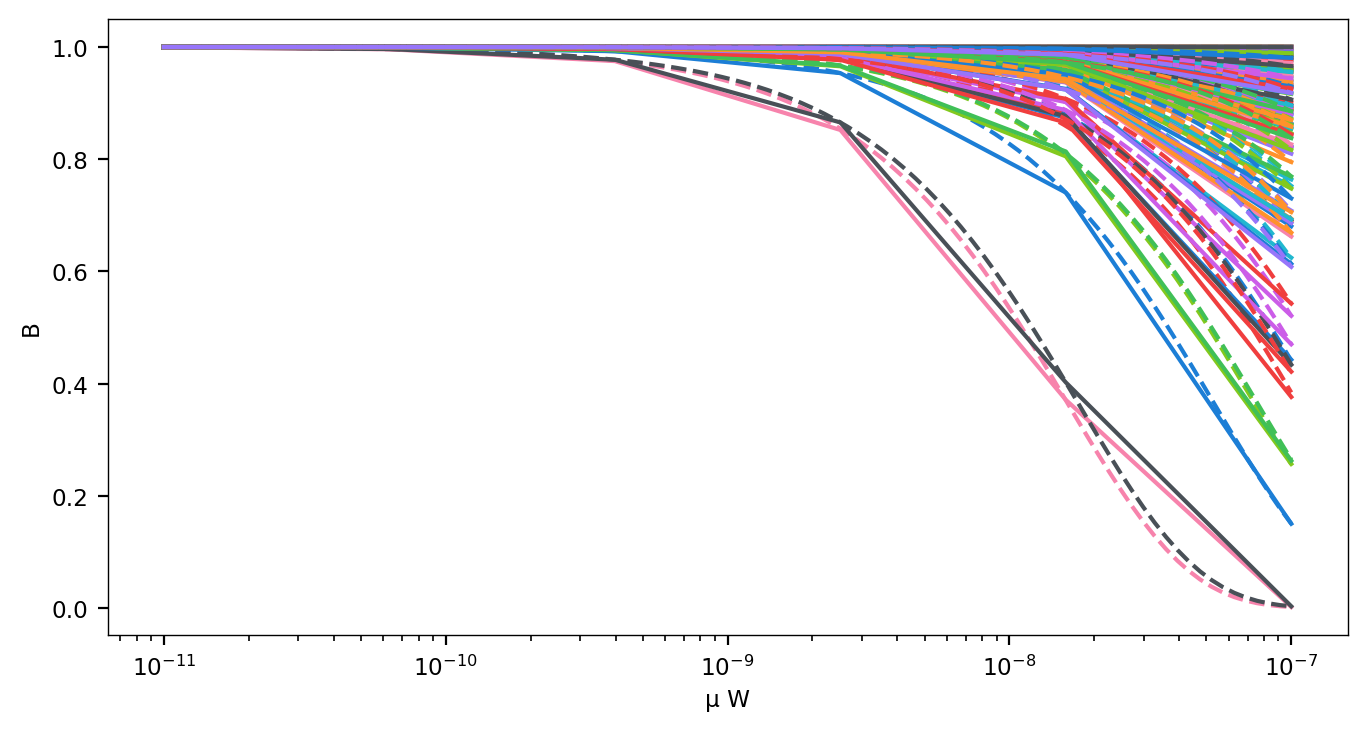

In [95]:
for i in range(0, bp.shape[0], 100):
    for j, t in enumerate(gm.t):
        lines = plt.plot(gm.w, np.exp(bp[i, :, j, 0]))
        popt, pcov = curve_fit(mut, mb.w, np.exp(bp[i, :, j, 0]))

        x = np.logspace(np.log10(mb.w[0]), np.log10(mb.w[-1]), 100)
        
        plt.plot(x, mut(x, *popt), c=lines[0].get_color(), linestyle='dashed')
        
plt.ylabel('B')
plt.xlabel('μ W')


plt.semilogx()
plt.legend()
#plt.ylim(0.99, 1)

In [74]:
from scipy.optimize import curve_fit

def mut(x, a):
    return np.exp(-a * x*2)

popt, pcov = curve_fit(mut, mb.w, np.exp(bp[1, :, 1, 0]))

In [76]:
mut(mb.w, *popt)

array([0.99999986, 0.99999913, 0.9999945 , 0.99996527, 0.99978088,
       0.99861824])

In [96]:
popt

array([427500.75473949])

[]

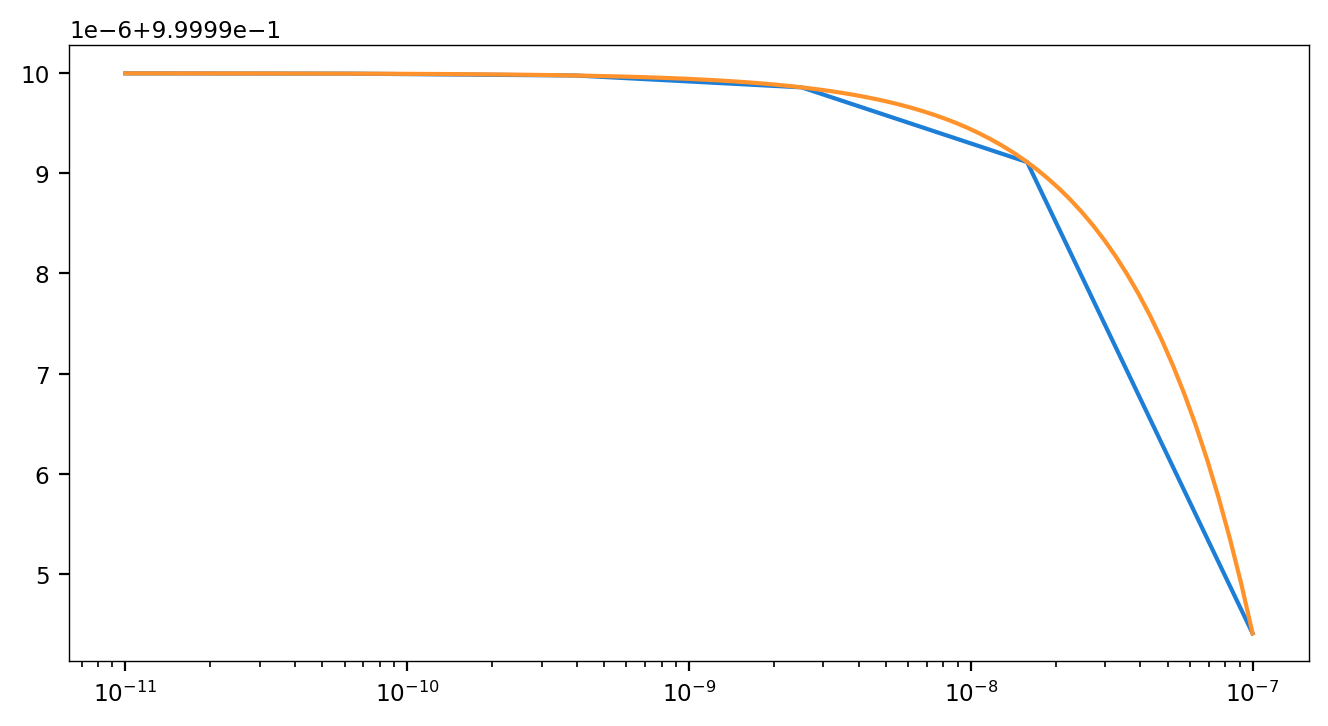

In [88]:
i = 400
j = 1

plt.plot(mb.w, np.exp(bp[i, :, j, 0]))

popt, pcov = curve_fit(mut, mb.w, np.exp(bp[i, :, j, 0]))

x = np.logspace(np.log10(mb.w[0]), np.log10(mb.w[-1]), 100)
plt.plot(x, mut(x, *popt))
plt.semilogx()

In [29]:
%%time

mb = SimplexModel(w=gm.w, t=gm.t, logB=bp, Y=Y,
                  bins=bgs_bins, features=features) 

mb.fit(starts=200, ncores=70, 
       softmax=False, #least_squares=True,
       #algo='GN_DIRECT_L'
       #algo='GN_ISRES'
       #algo='LD_LBFGS'
      )

CPU times: user 152 µs, sys: 358 µs, total: 510 µs
Wall time: 503 µs


In [20]:
mb

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates: (whole genome)
negative log-likelihood: 322778994011.57684
π0 = 0.0015806194012571296
μ = 4.11288064007961e-08
R² = 66.6049
W = 
          undefined
------  -----------
1e-07         0.239
1e-06         0.031
1e-05         0
0.0001        0
0.001         0.149
0.01          0.088
0.1           0.493

/home/vsb/projects/bprime/bgspy/optim.py:338: UserWarning: top_n < number of optimization results, truncating!
  warnings.warn(msg)


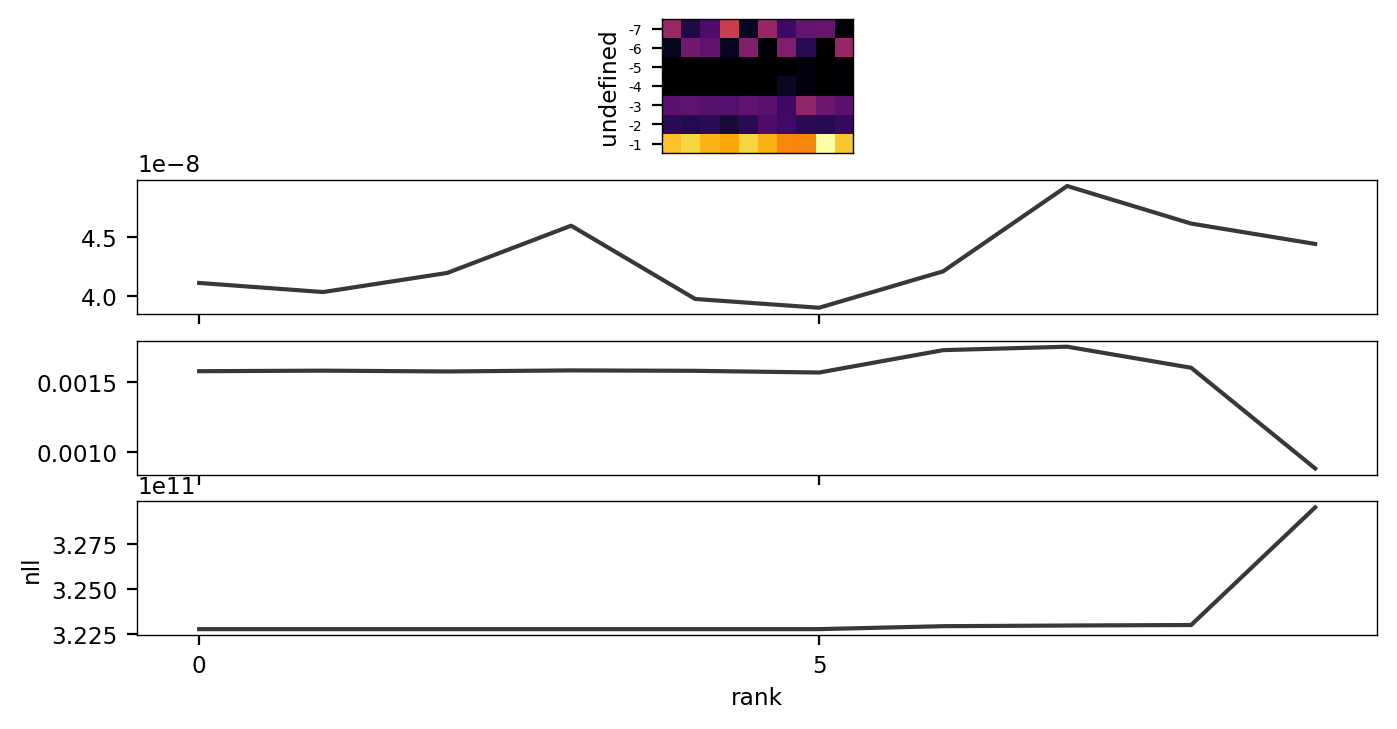

In [21]:
optim_diagnotics_plot(mb)

In [32]:
from scipy.interpolate import CubicSpline

In [34]:
bp.shape

(2496, 6, 7, 4)

In [44]:
np.poly1d(mb.w.shape[0])

poly1d([6])

In [45]:
CubicSpline(mb.w, bp[0, :, 0, 0]).c

array([[-6.82687933e+12, -6.82686232e+12,  2.65195375e+12,
        -3.30273276e+10, -3.30273276e+10],
       [ 6.23765458e+03,  5.15021327e+03, -1.71101767e+03,
         1.51059169e+04,  1.37844559e+04],
       [-7.43758115e+01, -7.43758109e+01, -7.43758097e+01,
        -7.43757814e+01, -7.43753961e+01],
       [-7.43758055e-10, -4.69279637e-09, -2.96095433e-08,
        -1.86823570e-07, -1.17877414e-06]])

In [39]:
chr1_fit.optim

OptimResult
  termination code: xtol reached
  stats: {'xtol reached': 46, 'max eval': 24} (prop success: 100.0%)
  negative log-likelihood = 27061062988.042805
  theta = [1.42960151e-03 2.88333066e-08 3.80362316e-02 7.23233251e-03
 8.98871356e-02 6.57812904e-01 6.62431860e-03 1.19617433e-01
 2.43413574e-04 3.22376582e-04 1.40730883e-05 1.70884905e-04
 1.17541014e-04 1.48109025e-04 7.84004045e-05 4.21579326e-02
 2.36955599e-01 4.64826604e-02 8.34307443e-01 1.41372181e-01
 2.57172788e-01 1.09237153e-01 4.12006357e-01]

In [33]:
chr1_fit

MLE (interpolated w): 6 x 7 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates: (chromosome chr1 only)
negative log-likelihood: 27065203107.190544
π0 = 0.001269826754051512
μ = 1.65925925925684e-08
R² = 64.7038
W = 
          cds    phastcons    utr
------  -----  -----------  -----
1e-07   0.445            0  0
1e-06   0                0  0
1e-05   0                0  0
0.0001  0                0  0
0.001   0                0  0.522
0.01    0                1  0.478
0.1     0.555            0  0

(<Figure size 1600x800 with 1 Axes>, <AxesSubplot: >)

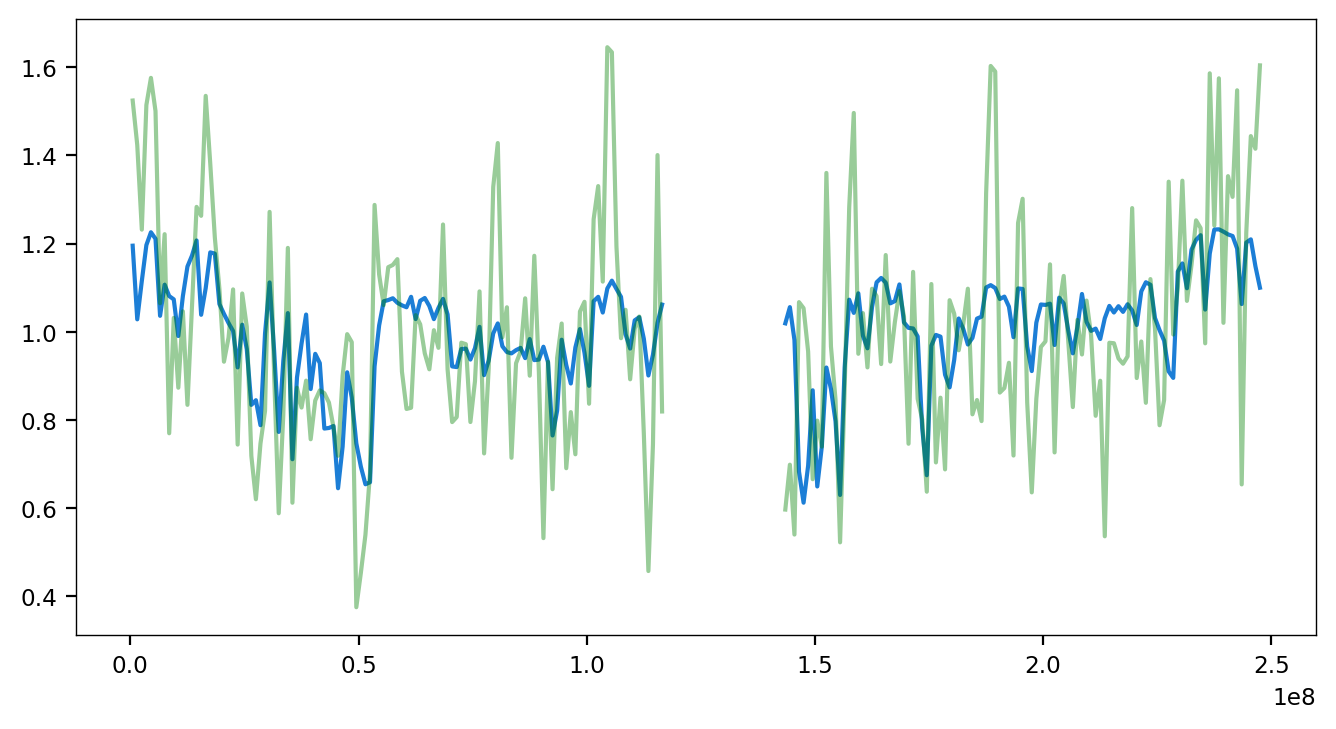

In [34]:
chr1_fit.predict_plot('chr1')

In [65]:
chr1_fit

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates: (chromosome chr1 only)
negative log-likelihood: 27064017315.81546
π0 = 0.0014728567498228575
μ = 3.2579620892649744e-08
R² = 65.6852
W = 
          undefined
------  -----------
1e-07         0.132
1e-06         0.047
1e-05         0
0.0001        0
0.001         0.071
0.01          0.405
0.1           0.345

In [ ]:
chr2_fit = mb.fit(starts=60000, ncores=70, 
       softmax=True, chrom='chr2',
       algo='LN_BOBYQA'
      )

In [25]:
mb

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

(<Figure size 1600x800 with 1 Axes>, <AxesSubplot: >)

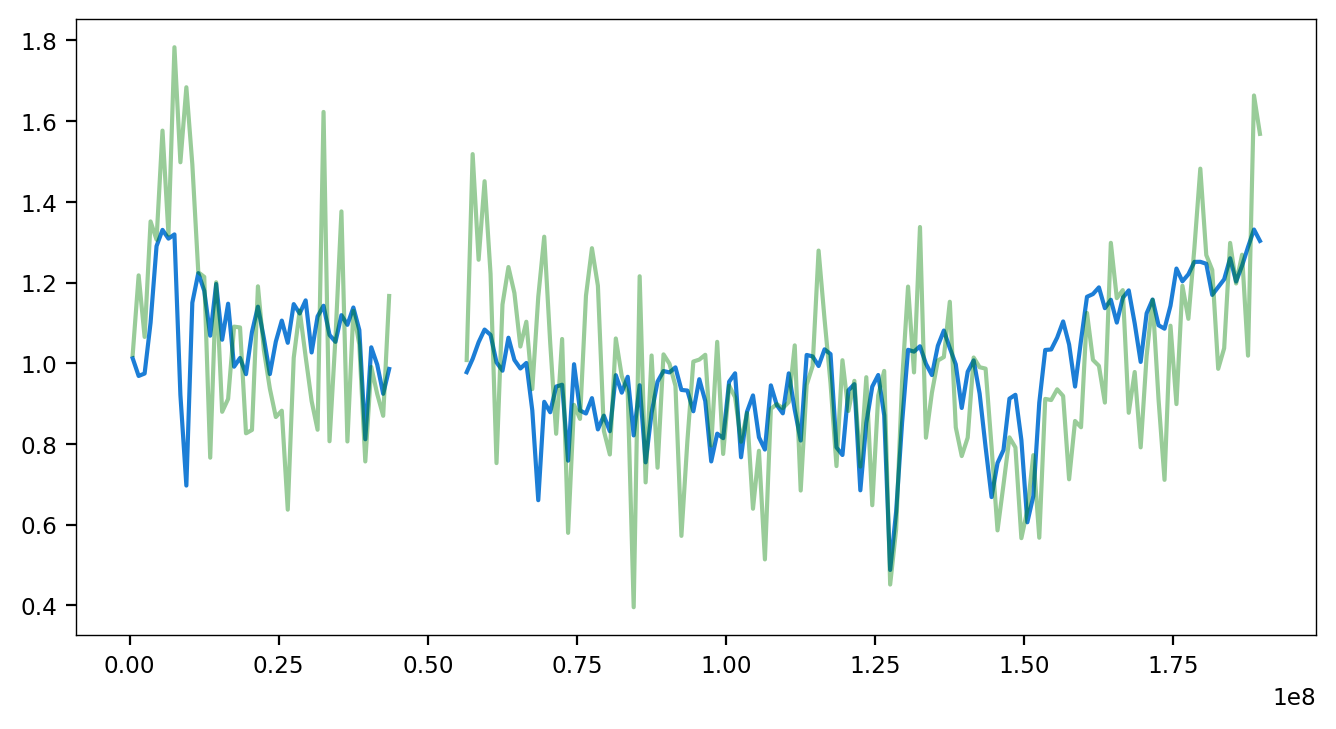

In [19]:
mb.predict_plot('chr4')

### Experiments

In [10]:
from bgspy.likelihood import negll_simplex_full, negll_softmax_full
from functools import partial

In [11]:
MU_SCALE = 1e-8
PI_SCALE = 1e-4

def negll_simplex_rescaled(theta_scaled, grad, Y, B, w):
    mu = theta_scaled[1] * MU_SCALE
    pi0 = theta_scaled[0] * PI_SCALE
    theta = np.copy(theta_scaled)
    theta[1] = mu
    theta[0] = pi0
    return negll_softmax_full(theta, grad, Y, B, w)
    #return negll_simplex_full(theta, grad, Y, B, w)

def rescale_start(theta):
    theta_scaled = np.copy(theta)
    theta_scaled[0] = theta_scaled[0] / PI_SCALE
    theta_scaled[1] = theta_scaled[1] / MU_SCALE
    for i in range(2, len(theta)-2):
        theta_scaled[i] = np.random.normal(0, 1, 1)
    return theta_scaled


In [105]:
mb = SimplexModel(w=gm.w, t=gm.t, logB=bp, Y=Y,
                  bins=bgs_bins, features=features) 

In [106]:
mb.random_start(softmax=True)

array([ 9.30069283e-04,  1.12342943e-08,  4.33237242e-01,  6.76691046e-01,
       -9.21513913e-01, -2.92808455e-02,  5.72837673e-02, -3.99233420e-01,
        8.46382537e-01,  9.65363649e-01,  1.16402292e+00,  2.32116523e-01,
        5.32228853e-01, -9.05250353e-01, -5.67842798e-01, -1.23138048e+00,
        4.03098132e-01,  1.31571236e+00,  1.08127496e+00,  6.02274913e-01,
        1.92996730e+00,  4.76481377e-01,  3.42854744e-01])

In [107]:
import nlopt
from bgspy.likelihood import negll_softmax_full

In [108]:
nt, nf = mb.nt, mb.nf
nparams = nt * nf + 2

opt = nlopt.opt('LD_LBFGS', nparams)
opt.set_min_objective(partial(negll_softmax_full, Y=Y, B=bp, w=mb.w))

In [109]:
mle = opt.optimize(mb.random_start(softmax=True))

In [35]:
def convert_softmax(theta_sm):
    theta = np.copy(theta_sm)
    theta[2:] = softmax(theta[2:].reshape(mb.nt, mb.nf), axis=0).flat
    return theta

convert_softmax(mle)[2:].reshape(mb.nt, mb.nf)

array([[0.16314965, 0.0499752 , 0.15791108],
       [0.17344978, 0.03098664, 0.13756693],
       [0.15947978, 0.1466461 , 0.05496592],
       [0.04048462, 0.23804359, 0.05709876],
       [0.15096566, 0.01189001, 0.13413082],
       [0.13595353, 0.06635368, 0.28867114],
       [0.176517  , 0.45610478, 0.16965534]])

In [36]:
opt.last_optimum_value()

373094368885.5542

In [110]:
#mb.fit(softmax=True, starts=100, algo='GN_DIRECT')

In [111]:
mb

MLE (interpolated w): 6 x 7 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

In [112]:
#simplex_bounds = list(zip(*(rescale_start(mb.bounds()[0]), rescale_start(mb.bounds()[1]))))
simplex_bounds = list(zip(*(mb.bounds()[0], mb.bounds()[1])))
simplex_bounds[2:] = [(None, None)]*(len(simplex_bounds)-2)
#simplex_bounds = [(None, None)]*(len(simplex_bounds))
simplex_bounds

[(0.0004999999999999999, 0.004999999999999999),
 (9.000000000000006e-09, 4.999999999999999e-08),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None)]

In [113]:
import multiprocessing
import tqdm
def opt(start):
    return minimize(partial(negll_softmax_full, grad=None, Y=Y, B=bp, w=gm.w), 
             bounds=simplex_bounds, 
             options={
                 #'maxiter': 1e6,
                 #'xatol': 1e-8,
                 #'adaptive': True,
                 #'fatol':1000
             },
             x0=start, 
             method='L-BFGS-B'
             #method='TNC',
             #method='Nelder-Mead'                   
            )

In [115]:
%%time 
NS = 10000
with multiprocessing.Pool(70) as p:
    bfgs = list(tqdm.tqdm(p.imap(opt, [mb.random_start() for r in range(NS)]), total=NS))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [175]:
nlls = np.array([r.fun for r in bfgs])
nll_idx = np.argsort(nlls)
min_i = nll_idx[1]
nlls[min_i]

323821632198.278

In [17]:
a = bfgs

In [160]:
nlls = [r.fun for r in a]
nll_idx = np.argsort(nlls)
min_i = nll_idx[0]
nlls[min_i]

322738283049.4047

In [18]:
a[nll_idx[1]].message

'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [19]:
nlls = [r.fun for r in a]
min_i = np.argmin(nlls)
nlls[min_i]

323801121624.9068

In [20]:
nlls = [r.fun for r in a]
nll_idx = np.argsort(nlls)
min_i = nll_idx[0]
nlls[min_i]

323801121624.9068

In [21]:
#a[min_i].x[0] * MU_SCALE, a[min_i].x[1] * PI_SCALE
a[min_i].x[0], a[min_i].x[1]

(0.001533083172058827, 2.6506112791649518e-08)

In [22]:
a[min_i].x[2:].reshape(mb.nt, mb.nf)

array([[ 0.43861248, -4.21680667, -0.41721338],
       [ 0.15517384, -3.85119856, -0.37498927],
       [ 0.12812948, -3.34786117, -0.38944758],
       [-1.04376041,  1.24324774, -0.09469992],
       [-0.51169828,  3.89885981,  0.34790112],
       [ 0.04601103,  3.45602202,  0.10424261],
       [ 1.79367388,  3.87962057,  1.86482758]])

In [23]:
a[nll_idx[0]].x

array([ 1.53308317e-03,  2.65061128e-08,  4.38612480e-01, -4.21680667e+00,
       -4.17213380e-01,  1.55173844e-01, -3.85119856e+00, -3.74989266e-01,
        1.28129483e-01, -3.34786117e+00, -3.89447575e-01, -1.04376041e+00,
        1.24324774e+00, -9.46999244e-02, -5.11698278e-01,  3.89885981e+00,
        3.47901120e-01,  4.60110345e-02,  3.45602202e+00,  1.04242613e-01,
        1.79367388e+00,  3.87962057e+00,  1.86482758e+00])

In [24]:
np.seterr(under='ignore')
np.round(softmax(a[nll_idx[0]].x[2:].reshape(mb.nt, mb.nf), axis=0), 2)

array([[0.13, 0.  , 0.06],
       [0.1 , 0.  , 0.06],
       [0.1 , 0.  , 0.06],
       [0.03, 0.03, 0.08],
       [0.05, 0.37, 0.12],
       [0.09, 0.24, 0.09],
       [0.51, 0.36, 0.54]])

In [25]:
np.round(softmax(a[nll_idx[1]].x[2:].reshape(mb.nt, mb.nf), axis=0), 2)

array([[0.22, 0.13, 0.21],
       [0.22, 0.18, 0.33],
       [0.22, 0.12, 0.18],
       [0.02, 0.02, 0.02],
       [0.06, 0.15, 0.04],
       [0.11, 0.15, 0.09],
       [0.15, 0.23, 0.14]])

In [26]:
np.round(softmax(a[nll_idx[5]].x[2:].reshape(mb.nt, mb.nf), axis=0), 2)

array([[0.2 , 0.08, 0.18],
       [0.2 , 0.08, 0.25],
       [0.19, 0.07, 0.15],
       [0.03, 0.02, 0.02],
       [0.06, 0.11, 0.05],
       [0.12, 0.2 , 0.1 ],
       [0.2 , 0.43, 0.26]])

In [170]:
dfes = []
for i in range(100):
    dfes.append(softmax(a[nll_idx[i]].x[2:].reshape(mb.nt, mb.nf), axis=0))

alpha = 0.05
#np.round(np.quantile(np.stack(dfes), (alpha/2, 1-alpha/2), axis=0), 3)
np.round(np.mean(np.stack(dfes), axis=0), 3)

array([[0.177, 0.037, 0.135],
       [0.182, 0.036, 0.131],
       [0.113, 0.024, 0.095],
       [0.011, 0.007, 0.014],
       [0.04 , 0.231, 0.043],
       [0.118, 0.363, 0.162],
       [0.358, 0.303, 0.419]])

In [171]:
mb.features

['cds', 'phastcons', 'utr']

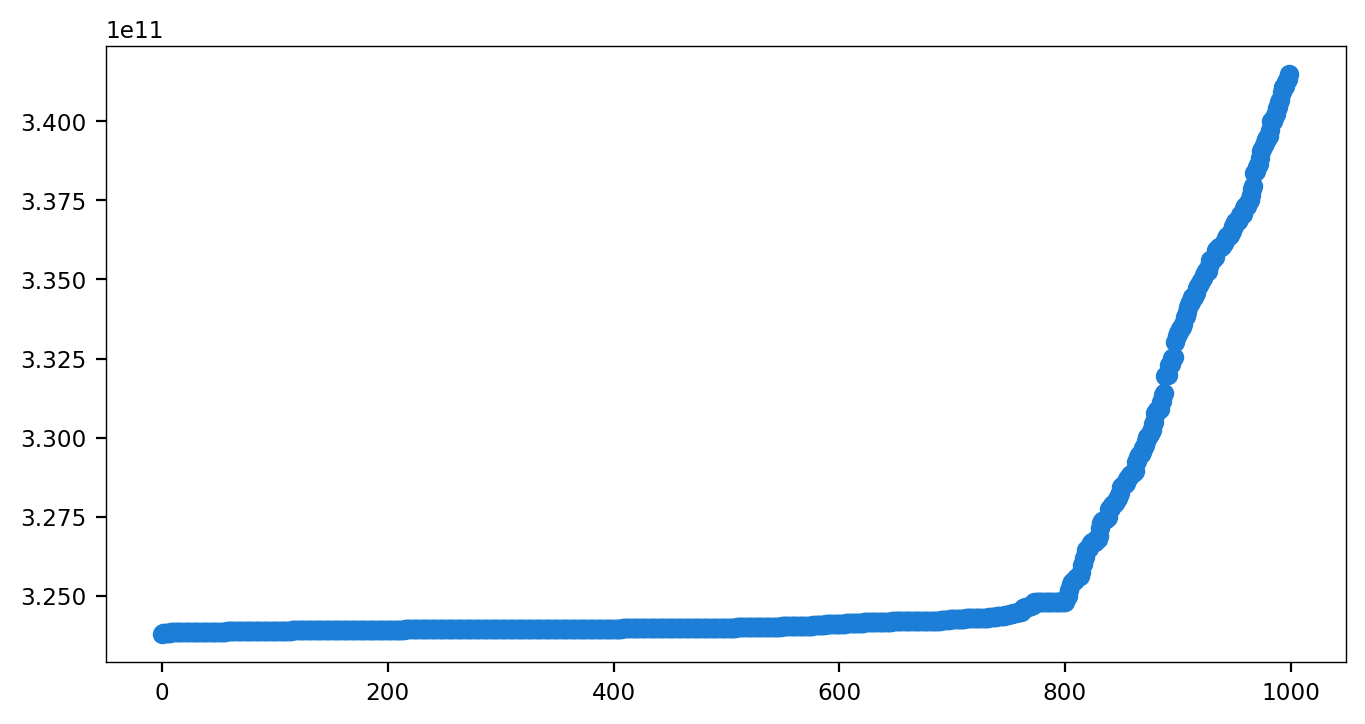

In [27]:
plt.scatter(np.arange(len(nlls)), np.sort(nlls))

Text(0.5, 0, 'rank')

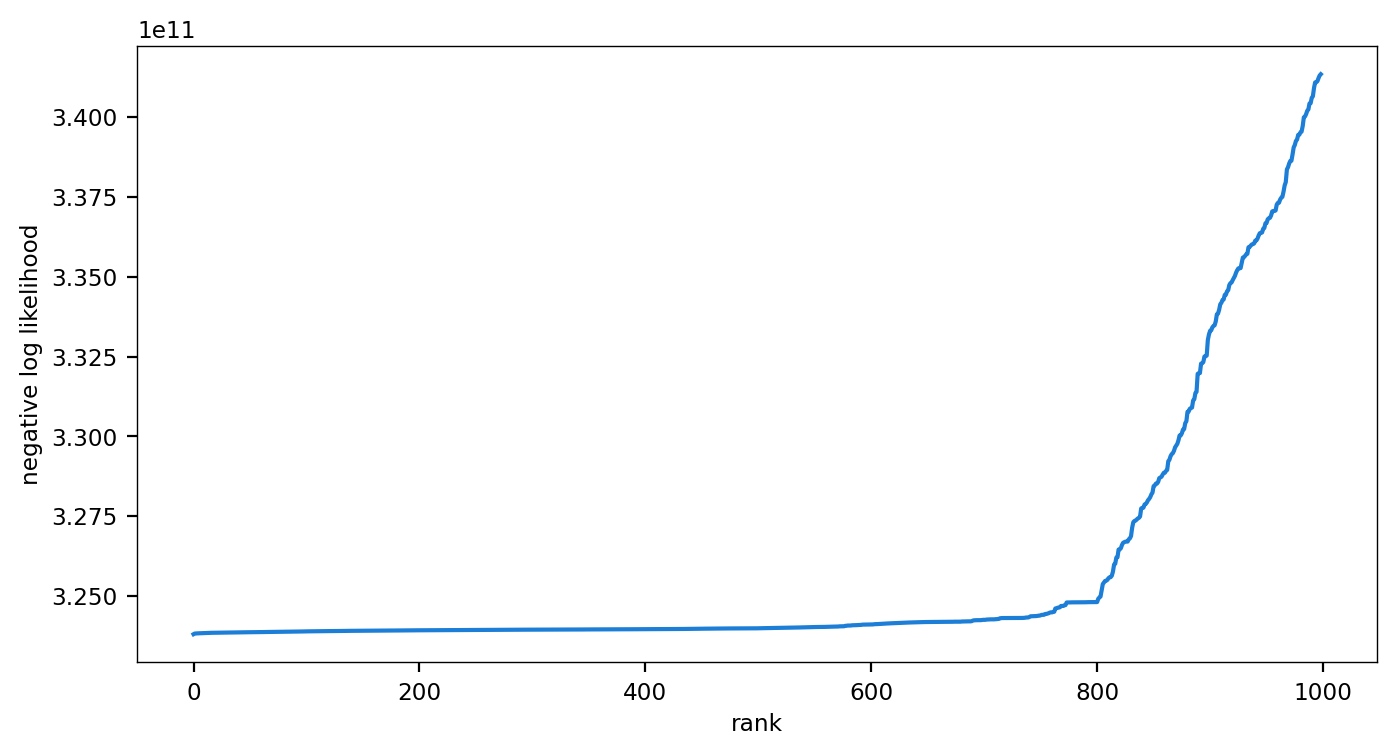

In [28]:
thresh = 1
plt.plot(np.arange(len(nlls))[:-thresh], np.sort(nlls)[:-thresh])
plt.ylabel('negative log likelihood')
plt.xlabel('rank')

In [211]:
a = mb.optim.thetas_
nlls = mb.optim.nlls_

In [75]:
mle = load_pickle('../fits/hg38_cds_utrs_phastcons_merged_simplex/fit_1000000/mle.pkl')

In [73]:
mle = load_pickle('../fits/hg38_cds_utrs_phastcons_merged_simplex/fit_1000000/mle_softmax.pkl')

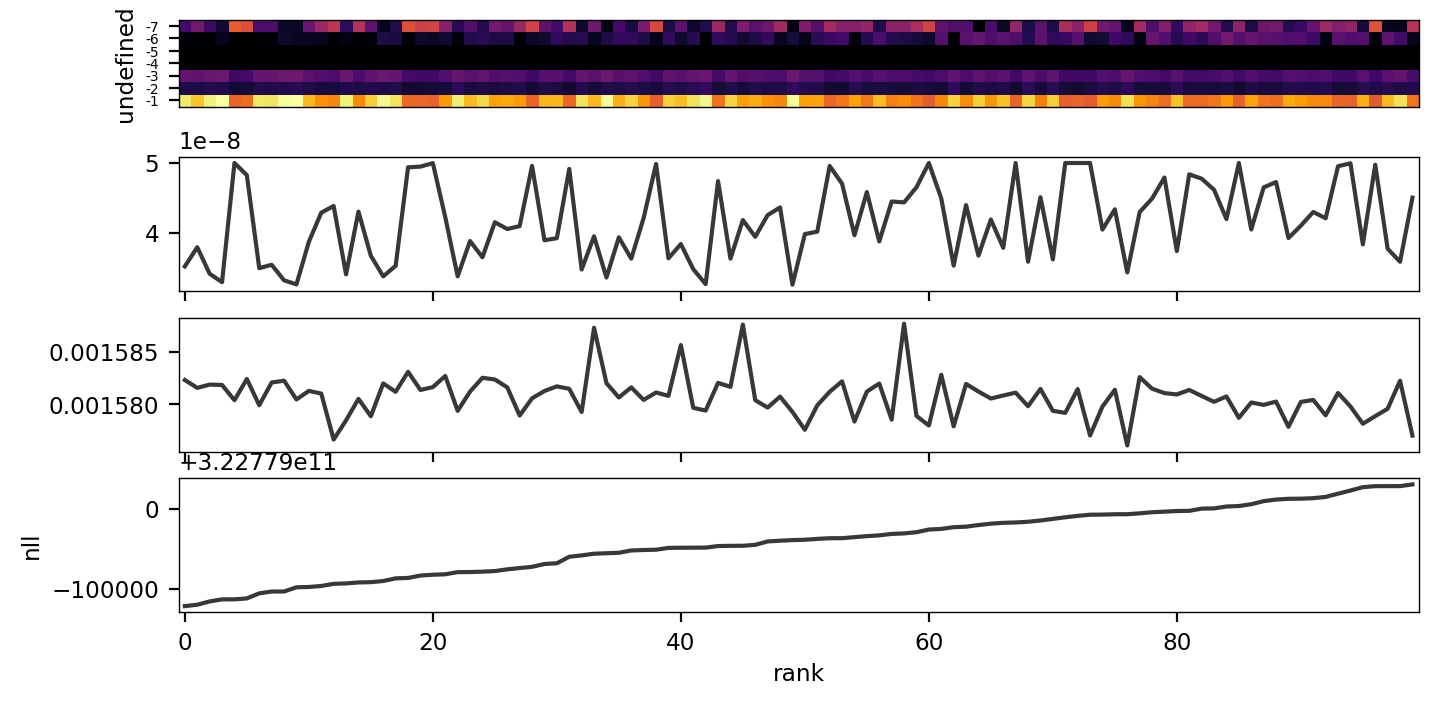

In [103]:
from bgspy.optim import optim_diagnotics_plot
optim_diagnotics_plot(mle['m_bp'], top_n=100)

In [98]:
mle['m_bp'].bounds()

(array([5.e-04, 9.e-09, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00]),
 array([5.e-03, 5.e-08, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00,
        1.e+00]))

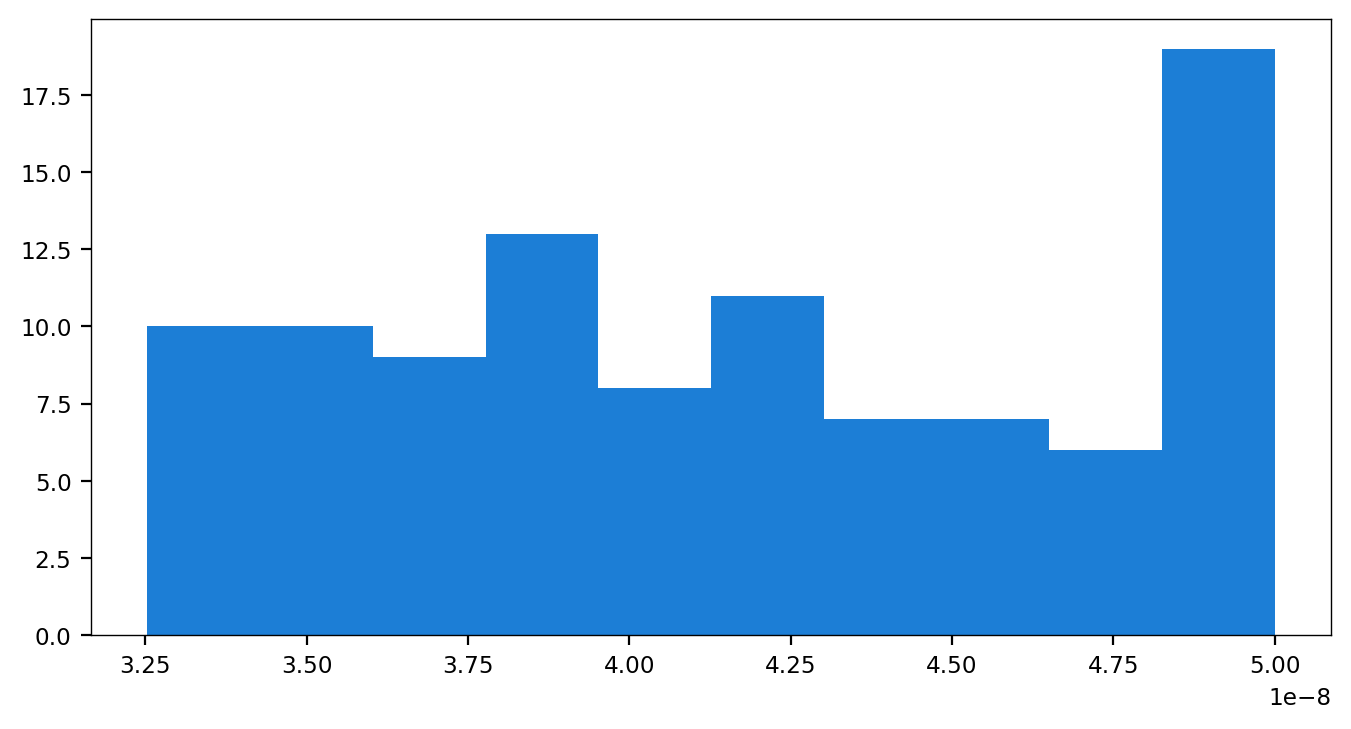

In [90]:
_ = plt.hist([x[1] for x in mle['m_bp'].optim.thetas_[:100]])

Text(0.5, 0, 'rank')

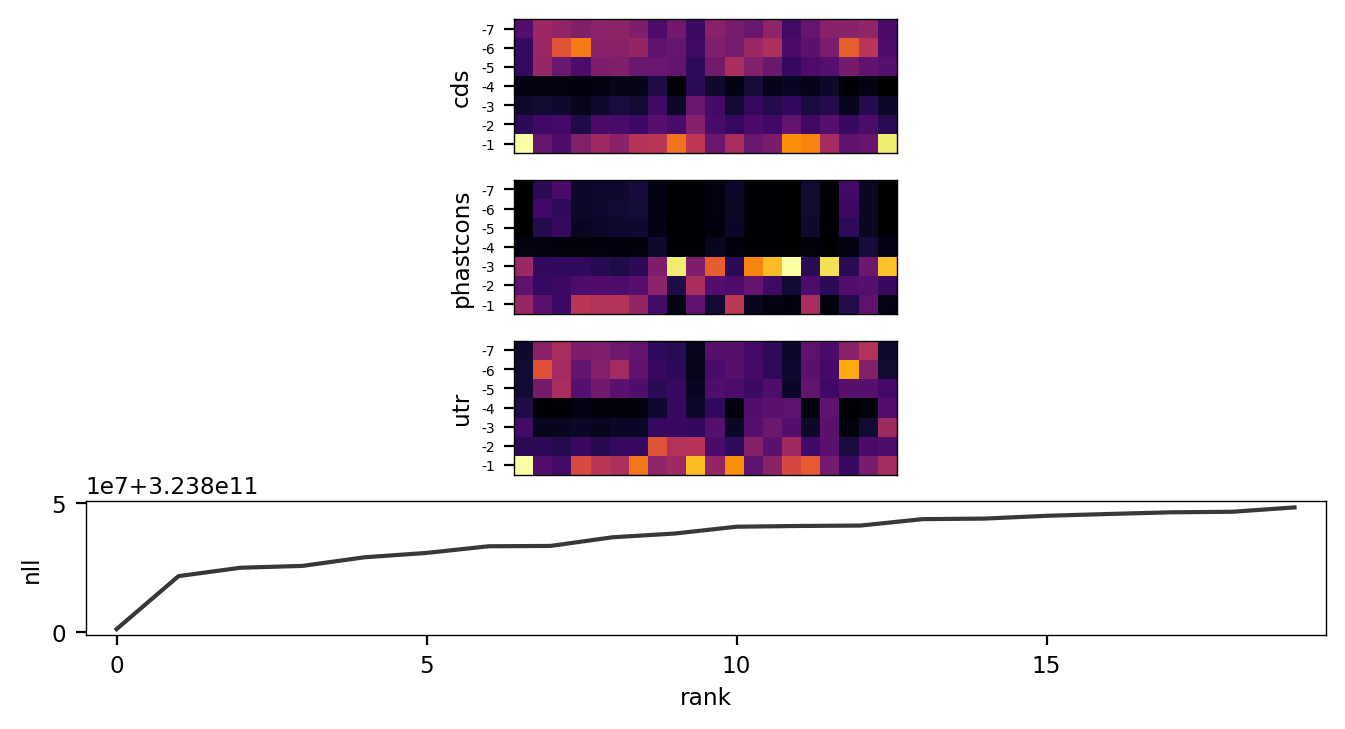

In [174]:
top_n = 20

dfes = []
for i in range(top_n):
    dfes.append(softmax(a[nll_idx[i]].x[2:].reshape(mb.nt, mb.nf), axis=0))
    #dfes.append(softmax(a[i, :][2:].reshape(mb.nt, mb.nf), axis=0))

dfes = np.stack(dfes)
#dfes = dfes - np.mean(dfes, axis=0)

fig, ax = plt.subplots(ncols=1, nrows=mb.nf + 1, sharex=True)

for i in range(mb.nf):
    ax[i].imshow(dfes[:, :, i].T, cmap='inferno')
    ax[i].set_ylabel(f"{features[i]}")
    ax[i].set_yticks(np.arange(mb.nt), np.log10(mb.t).astype(int))
    ax[i].xaxis.set_visible(False)
    ax[i].tick_params(axis='y', which='major', labelsize=5)
thresh = 1
i += 1
# ax[i].scatter(np.arange(len(nlls))[:top_n], np.sort(nlls)[:top_n], 
#               c=[{True: 'black', False: 'red'}[x.success] for x in a][:top_n],
#              s=2)
ax[i].plot(np.arange(len(nlls))[:top_n], np.sort(nlls)[:top_n], c='0.22')
ax[i].set_ylabel('nll')
ax[i].set_xlabel('rank')


In [32]:
mb.theta_ = a[min_i].x

In [38]:
def convert_softmax(theta_sm):
    theta = np.copy(theta_sm)
    theta[2:] = softmax(theta[2:].reshape(mb.nt, mb.nf), axis=0).flat
    return theta

#mb.theta_ = mb.random_start() #convert_softmax(a[-1].x)
mb.theta_ = convert_softmax(a[min_i].x)
mb.nll_ = nlls[min_i]

(<Figure size 1600x800 with 1 Axes>, <AxesSubplot: >)

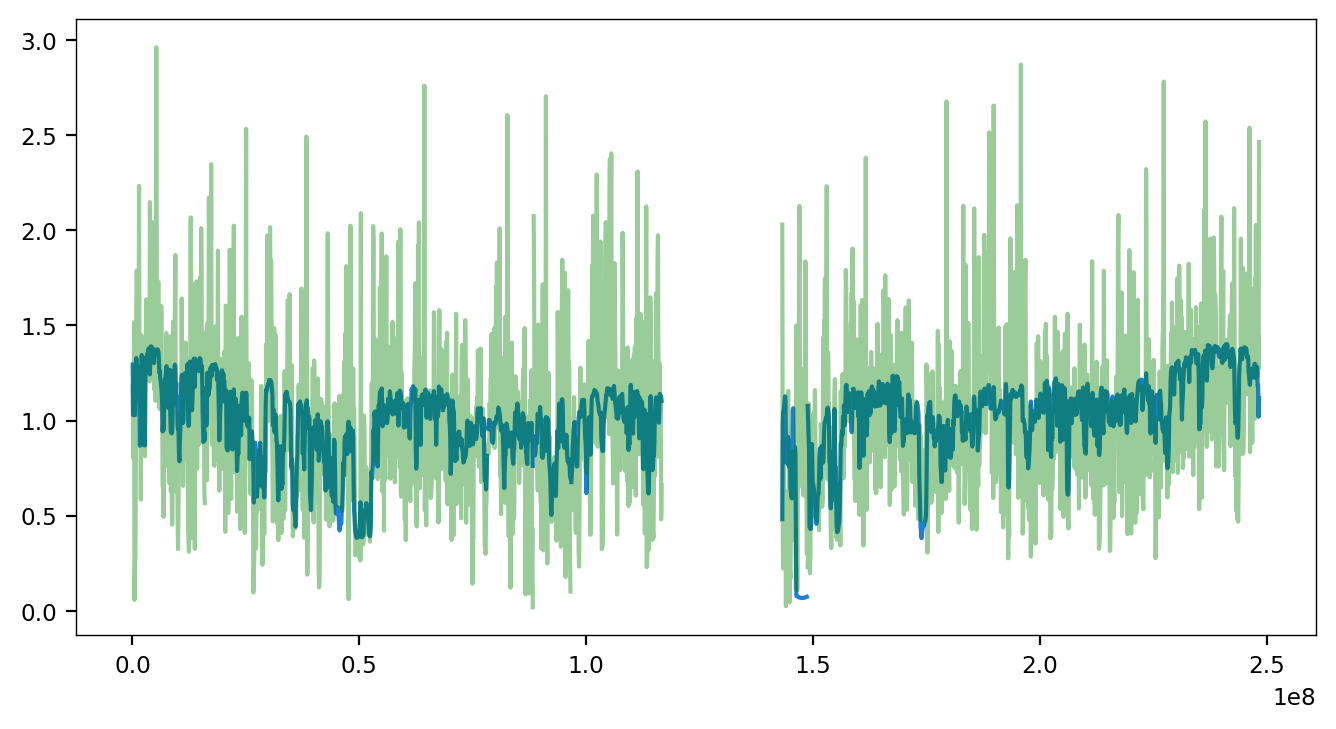

In [39]:
mb.predict_plot('chr1')

In [ ]:
mb.fit(starts=100, ncores=70, softmax=True)

In [80]:
mb.theta_ = convert_softmax(bfgs[min_i].x)

(<Figure size 1600x800 with 1 Axes>, <AxesSubplot: >)

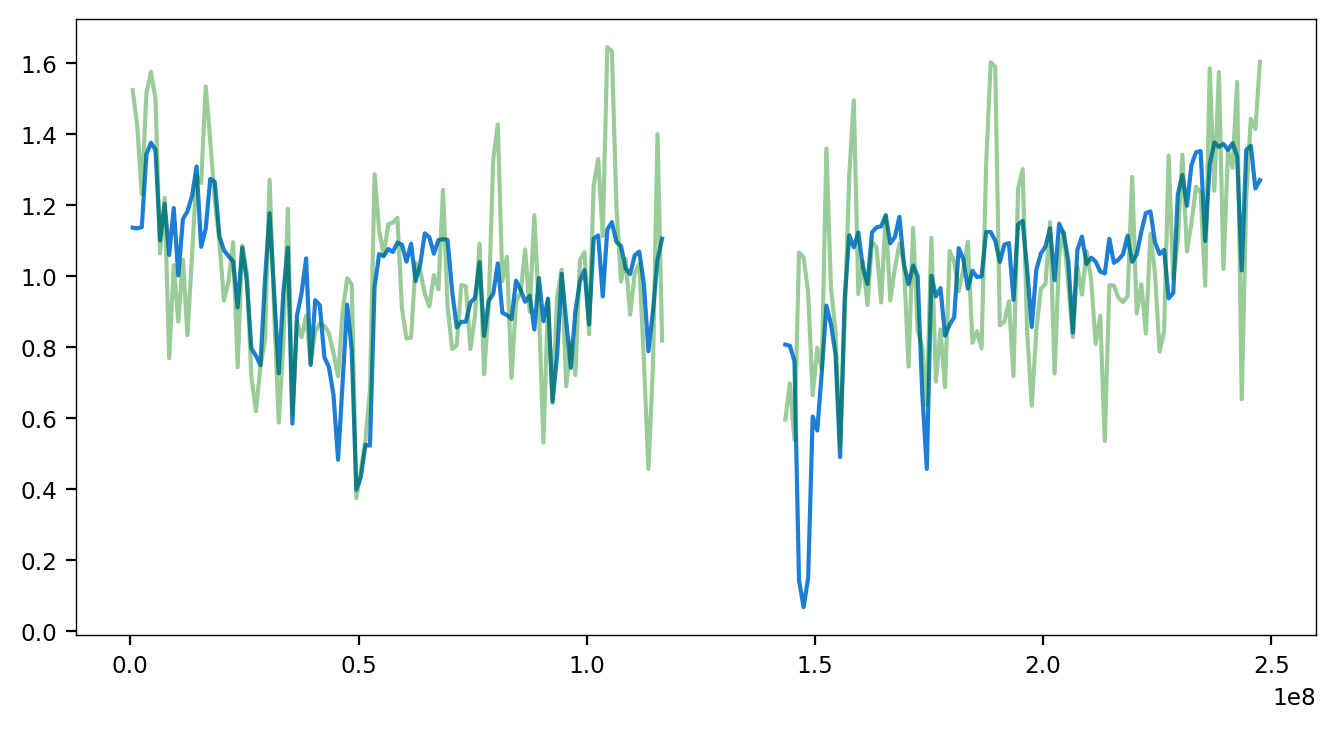

In [81]:
mb.predict_plot('chr1')


(<Figure size 1600x800 with 1 Axes>,
 <AxesSubplot: xlabel='predicted $\\hat{\\pi}$', ylabel='residuals'>)

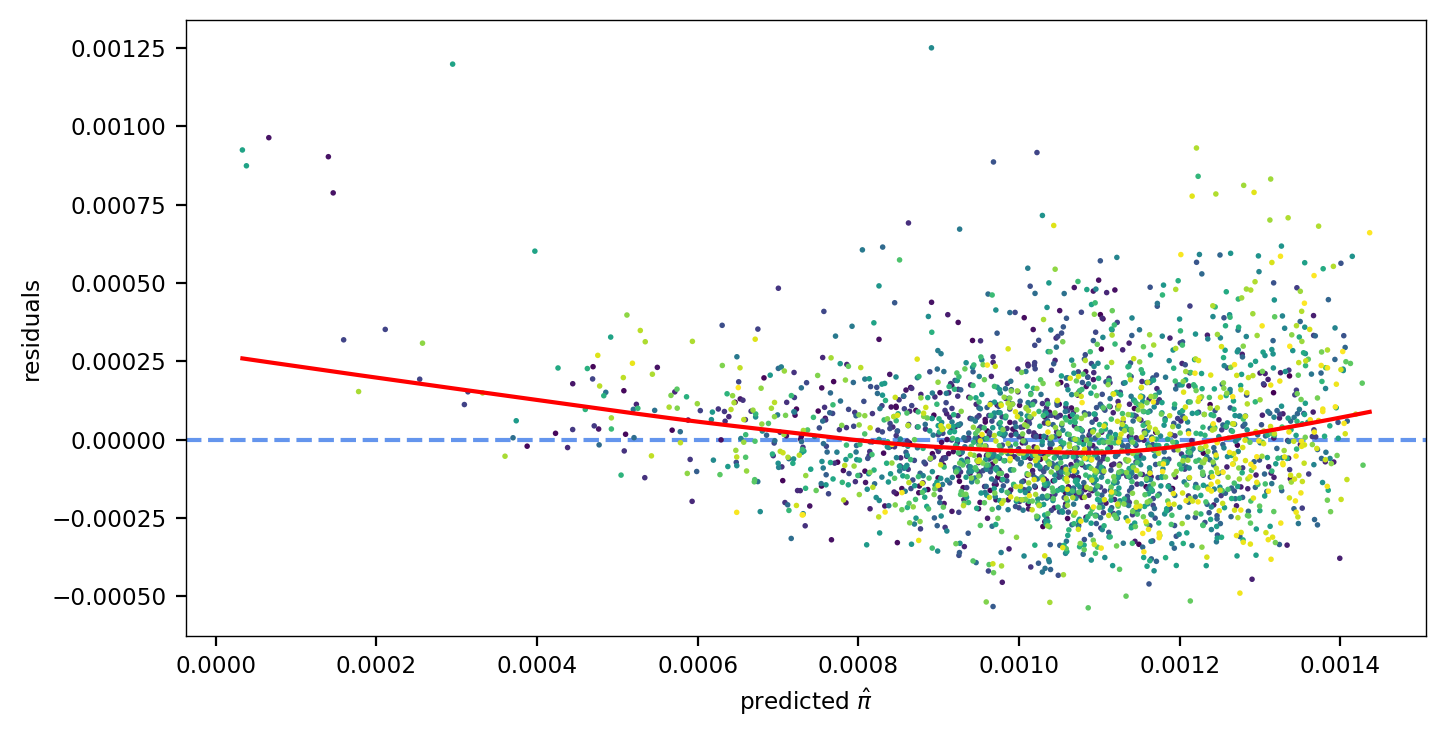

In [82]:
mb.resid_fitted_plot()
#plt.semilogx()
#plt.xlim(1e-9, 1e-1)


(<Figure size 1600x800 with 1 Axes>, <AxesSubplot: >)

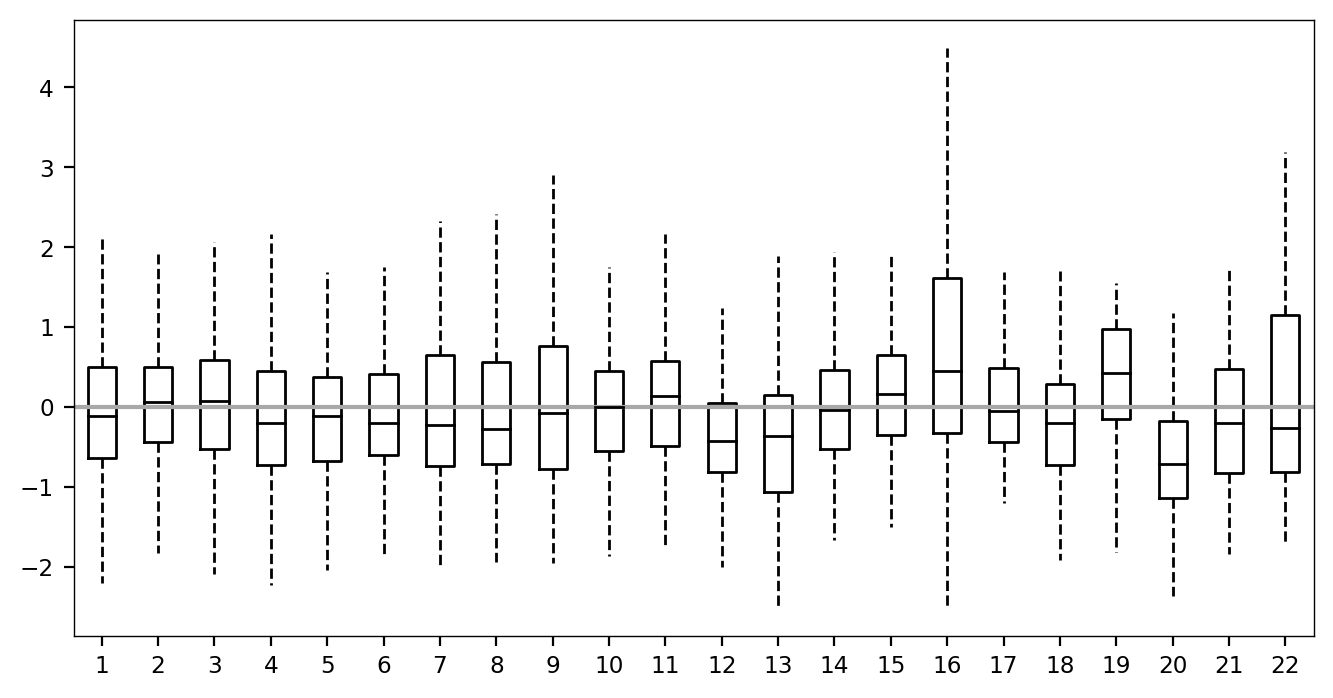

In [170]:
mb.chrom_resid_plot()

In [173]:
mb.nll_ = nlls[min_i]
mb

MLE (interpolated w): 6 x 7 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 323801121624.9068
π0 = 0.001533083172058827
μ = 2.6506112791649518e-08
R² = 68.1189
W = 
          cds    phastcons    utr
------  -----  -----------  -----
1e-07   0.131        0      0.055
1e-06   0.098        0      0.058
1e-05   0.096        0      0.057
0.0001  0.03         0.026  0.076
0.001   0.051        0.371  0.119
0.01    0.088        0.238  0.093
0.1     0.507        0.364  0.542

In [209]:
%%time 
mb.fit(ncores=70, starts=100, start_pi0=0.0015, start_mu=3e-8, algo='GN_ISRES')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [56:34<00:00, 33.95s/it]


CPU times: user 785 ms, sys: 19 s, total: 19.8 s
Wall time: 56min 54s


In [210]:
mb

MLE (interpolated w): 6 x 7 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 322730856130.1677
π0 = 0.001548282636298154
μ = 3.3456171082384254e-08
R² = 68.3494
W = 
          cds    phastcons    utr
------  -----  -----------  -----
1e-07   0.083        0.002  0.175
1e-06   0.865        0      0.025
1e-05   0.029        0      0.029
0.0001  0            0      0.039
0.001   0            0.238  0.115
0.01    0            0.359  0.067
0.1     0.024        0.402  0.549

In [14]:
m_b.optim

OptimResult
  termination code: xtol reached
  stats: {'xtol reached': 1992, 'max eval': 8} (prop success: 100.0%)
  negative log-likelihood = 322778981134.79486
  theta = [1.58288477e-03 3.00449198e-08 3.60169419e-04 5.06109943e-04
 2.42576328e-05 2.81284967e-04 2.14794012e-01 8.35385118e-02
 7.00650041e-01]

In [11]:
m_b

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 322778994608.46765
π0 = 0.001582883595483872
μ = 4.496758587745205e-08
R² = 66.6214
W = 
          undefined
------  -----------
1e-07         0.313
1e-06         0.018
1e-05         0
0.0001        0
0.001         0.142
0.01          0.061
0.1           0.465

In [50]:
m_b

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 322778986520.9623
π0 = 0.0015824358718647073
μ = 3.281030904802272e-08
R² = 66.6248
W = 
          undefined
------  -----------
1e-07         0.071
1e-06         0.014
1e-05         0
0.0001        0
0.001         0.196
0.01          0.079
0.1           0.639

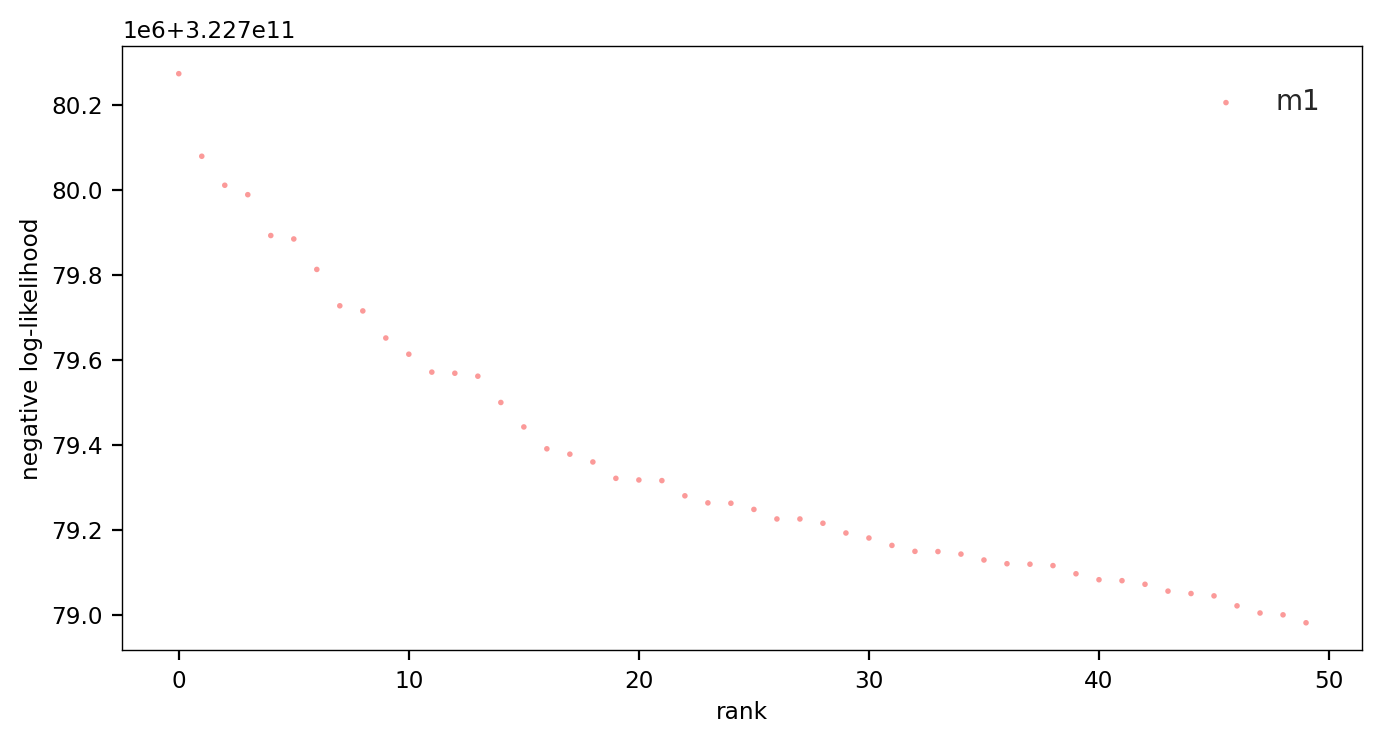

In [17]:
optim_plot(m1=mb.optim)

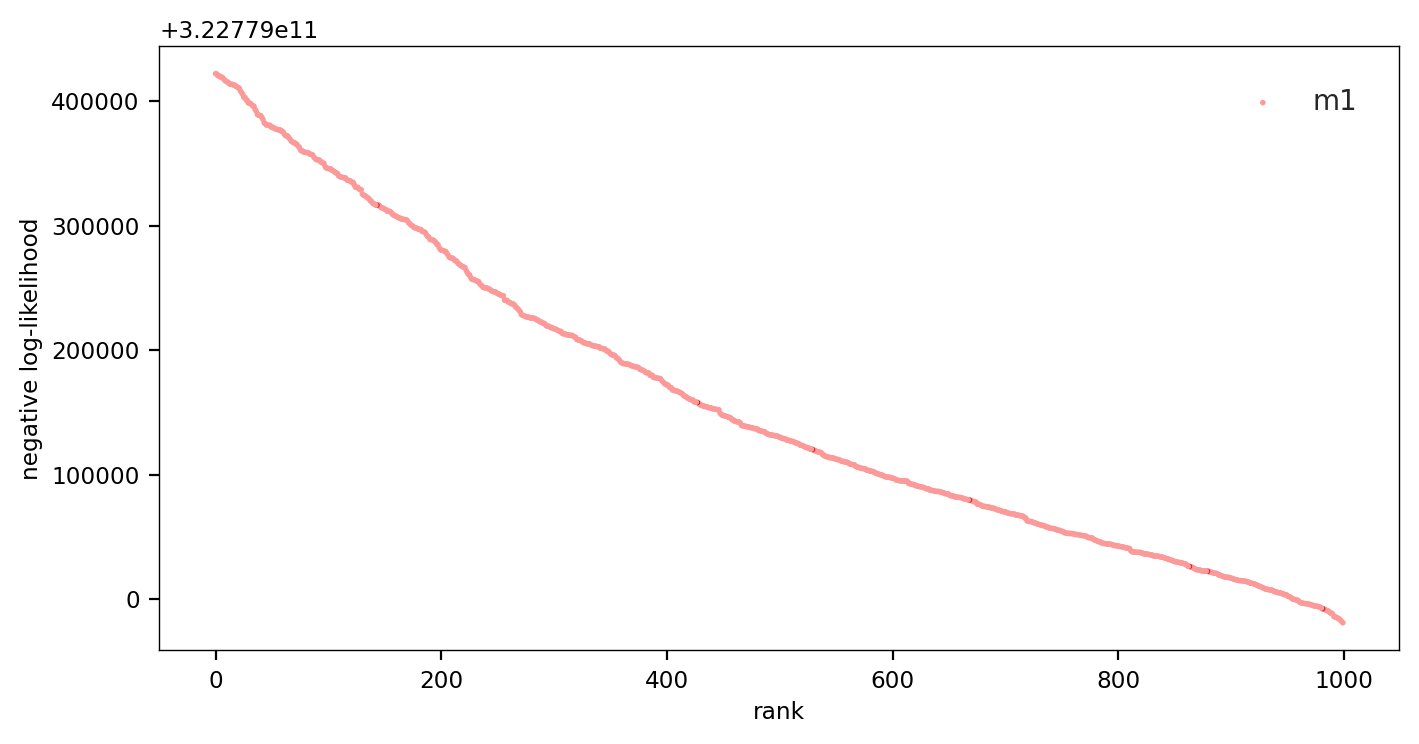

In [13]:
optim_plot(m1=m_b.optim)

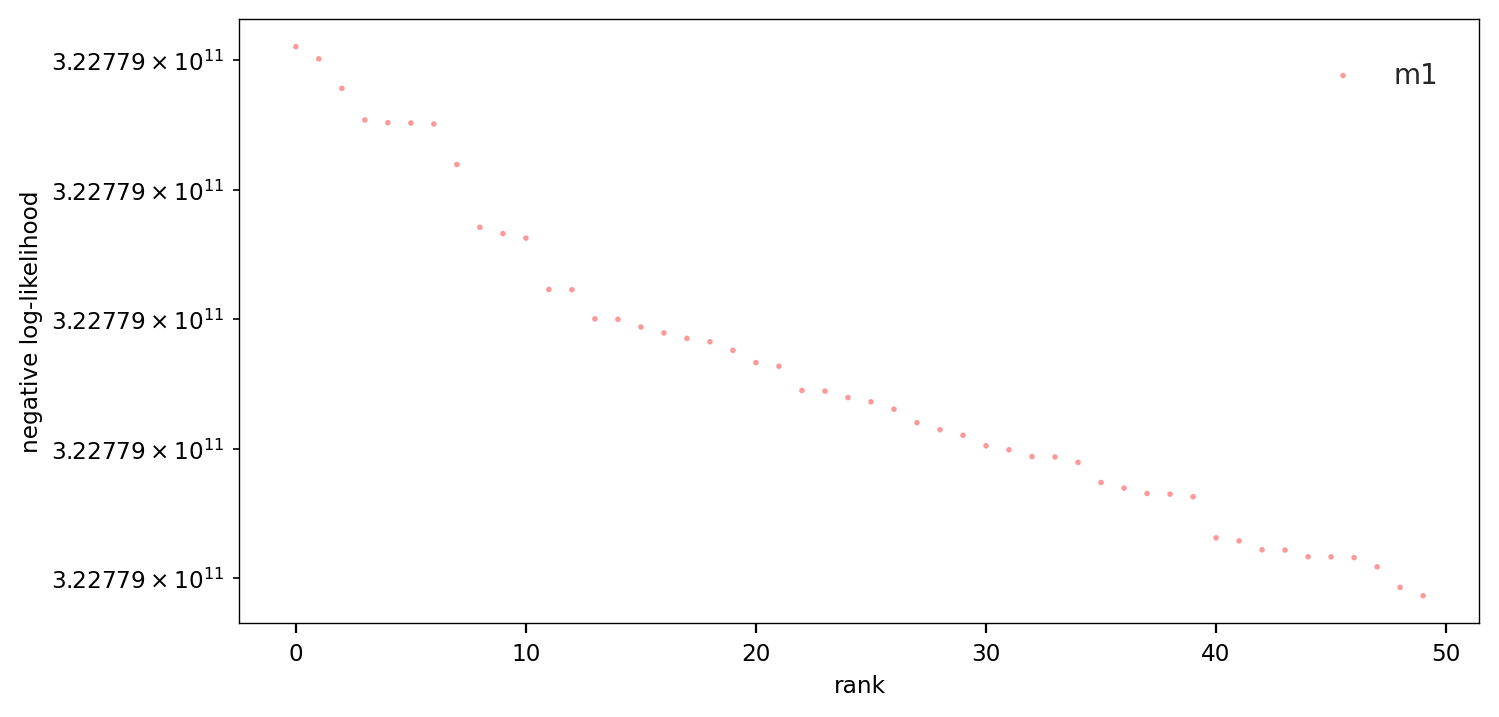

In [56]:
optim_plot(m1=m_b.optim)

In [15]:
m_b.fit(ncores=50, starts=1, start_pi0=0.0015, start_mu=3e-8, algo='GN_ISRES')

  0%|          | 0/1 [00:00<?, ?it/s]

> /home/vsb/projects/bprime/bgspy/optim.py(188)nlopt_simplex_worker()
    186     log10_mu_bounds = bounds[0][1], bounds[1][1]  # TODO CHECK
    187     __import__('pdb').set_trace()
--> 188     hl, hu = inequality_constraint_functions(nt, nf, mu=mu, 
    189                                              log10_mu_bounds=log10_mu_bounds)
    190     # tolerances for inequality constraint



ipdb>  log10_mu_bounds


(1e-11, 1e-07)


ipdb>  exit


BdbQuit: 

### CDS + UTRs + Phastcons Model

In [ ]:
fd = load_pickle('../fits/hg38_cds_utrs_phastcons_simplex/model_data.pkl')
gm, Y, bgs_bins, features, bp = fd['gm'], fd['Y'], fd['bgs_bins'], fd['gm'], fd['bp']

In [32]:
10**np.array(tuple(np.log10((0.0005, 0.005))))

array([0.0005, 0.005 ])

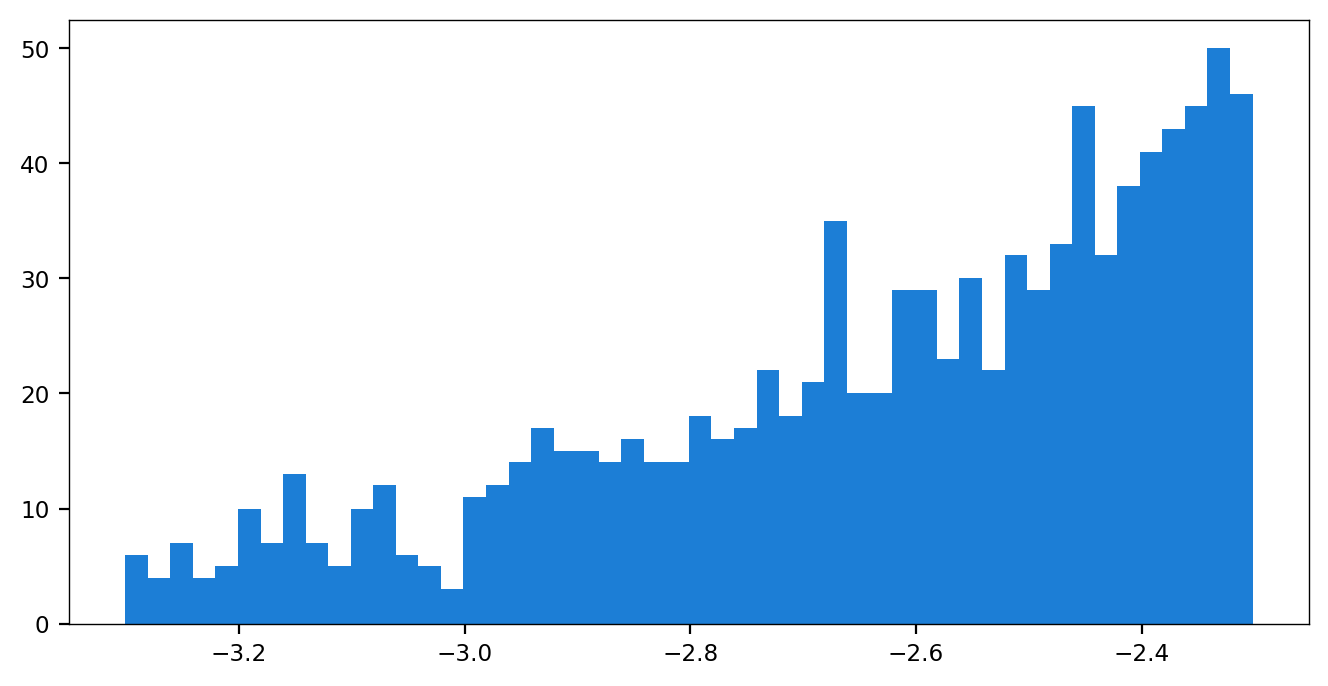

In [44]:
_ = plt.hist(np.log10([m_b.random_start()[0] for x in range(1000)]), 50)

In [39]:
from bgspy.data import pi_from_pairwise_summaries
pi_from_pairwise_summaries(Y.sum(axis=0))

0.001052746703898515

In [18]:
m_b

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 322791293316.3191
π0 = 0.0015787476785369746
μ = 6.407820745658771e-08
R² = 66.2317
W = 
          undefined
------  -----------
1e-07         0.022
1e-06         0.393
1e-05         0.127
0.0001        0
0.001         0.064
0.01          0.112
0.1           0.281

In [21]:
m_b

MLE (interpolated w): 6 x 7 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 322741693444.99133
π0 = 0.001559728773284351
μ = 3.855877895183788e-08
R² = 67.8068
W = 
          cds    phastcons    utr
------  -----  -----------  -----
1e-07   0.32         0.055  0.241
1e-06   0.228        0.007  0.202
1e-05   0.008        0.003  0.133
0.0001  0.001        0.001  0.02
0.001   0.001        0.148  0.063
0.01    0.266        0.414  0.196
0.1     0.177        0.372  0.146

In [10]:
%%time
m_b.fit(ncores=70, starts=100, algo='GN_ISRES')

  0%|          | 0/100 [00:00<?, ?it/s]

Process ForkPoolWorker-140:
Process ForkPoolWorker-136:
Process ForkPoolWorker-117:
Process ForkPoolWorker-88:
Process ForkPoolWorker-125:


KeyboardInterrupt: 